In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Data visualization

In [5]:
train_data = pd.read_csv('data/annotations.csv')

In [6]:
train_data.head(5)

Unnamed: 0   image_id  width  height   source      x      y      w      h
0           0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0
1           1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0
2           2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0
3           3  b6ab77fd7   1024    1024  usask_1  834.0   95.0  109.0  107.0
4           4  b6ab77fd7   1024    1024  usask_1   26.0  144.0  124.0  117.0

In [7]:
train_data['image_id'].value_counts()

35b935b6c    116
f1794c924    108
f79336a8e    104
134d4a01c    101
4cf91995d     97
            ... 
86296fc32      1
ce4124be0      1
4e6c05213      1
a5cb30c38      1
41457a646      1
Name: image_id, Length: 3373, dtype: int64

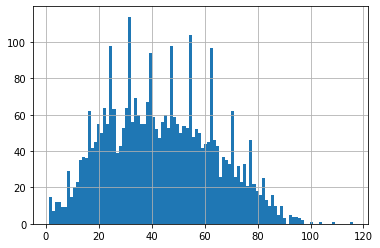

In [8]:
#number of boxes on image histogram
train_data['image_id'].value_counts().hist(bins=100)

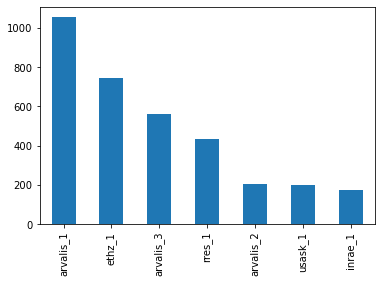

In [9]:
#source distribution
train_data.groupby('image_id')['source'].first().value_counts().plot(kind='bar')

## Config testing

In [10]:
!python utils/split_data.py --train_size=100 --proportion=0.85

49 unlabeled images were found


In [13]:
train_ids = pd.read_csv('data/train.txt', header=None)
train_ids.columns= ["image_id"]

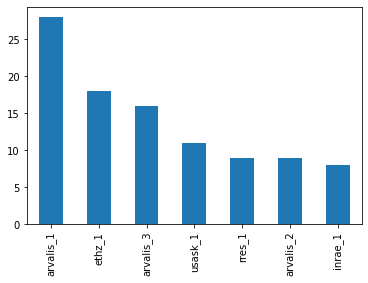

In [14]:
#region distribution in chosen data
partial_train_data = pd.merge(train_data, train_ids, how='inner', on='image_id')
partial_train_data.groupby('image_id')['source'].first().value_counts().plot(kind='bar')

### Train faster rcnn on 100 images

In [ ]:
!python train.py --config=configs/faster_rcnn/faster_rcnn_r50_fpn_mstrain_3x_wheat.py --max_epochs=3

In [ ]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

model = init_detector('configs/faster_rcnn/faster_rcnn_r50_fpn_mstrain_3x_wheat.py', 'experiments/faster_rcnn/r50_fpn/latest.pth', device='cuda:0') 
img = 'data/test/2fd875eaa.jpg'
result = inference_detector(model, img)

show_result_pyplot(model, img, result, score_thr=0.3)

### Train yolox on 100 images

In [ ]:
!python train.py --config=configs/yolox/yolox_tiny_8x8_300e_wheat.py --max_epochs=75

In [ ]:
model = init_detector('configs/yolox/yolox_tiny_8x8_300e_wheat.py', 'experiments/yolox/yolox_tiny/latest.pth', device='cuda:0') 
img = 'data/test/2fd875eaa.jpg'
result = inference_detector(model, img)

show_result_pyplot(model, img, result, score_thr=0.3)

## Model parameters search

In [ ]:
from model_search import faster_rcnn_model_search

faster_rcnn_model_search()

In [ ]:
from model_search import yolo_model_search

yolo_model_search()

In [1]:
from model_search import aggregate_results

aggregate_results()

+----------------------------------------------------------------------------------------------------+------+
|                                                                                                    |   mAP|
+----------------------------------------------------------------------------------------------------+------+
|                                                                             Faster-RCNN ResNet50 L1| 0.915|
+----------------------------------------------------------------------------------------------------+------+
|                                                                        Faster-RCNN ResNet50 IoULoss| 0.915|
+----------------------------------------------------------------------------------------------------+------+
|                                                                            Faster-RCNN ResNet101 L1| 0.917|
+----------------------------------------------------------------------------------------------------+------+
|         

In [7]:
models_info = pd.read_csv('models_info.csv', delimiter='\t')
models_info.head(10)

name  score  \
0        Faster-RCNN ResNet50 L1  0.915   
1   Faster-RCNN ResNet50 IoULoss  0.915   
2       Faster-RCNN ResNet101 L1  0.917   
3  Faster-RCNN ResNet101 IoULoss  0.916   
4               YOLOX yolox-tiny  0.915   
5              YOLOX yolox-small  0.937   

                                          checkpoint  \
0  checkpoints\faster_rcnn\faster_rcnn_ResNet50_L...   
1  checkpoints\faster_rcnn\faster_rcnn_ResNet50_I...   
2  checkpoints\faster_rcnn\faster_rcnn_ResNet101_...   
3  checkpoints\faster_rcnn\faster_rcnn_ResNet101_...   
4             checkpoints\yolox\yolox-tiny_wheat.pth   
5            checkpoints\yolox\yolox-small_wheat.pth   

                                              config  \
0  configs/faster_rcnn/faster_rcnn_r50_fpn_mstrai...   
1  configs/faster_rcnn/faster_rcnn_r50_fpn_mstrai...   
2  configs/faster_rcnn/faster_rcnn_r101_fpn_mstra...   
3  configs/faster_rcnn/faster_rcnn_r101_fpn_mstra...   
4         configs/yolox/yolox_tiny_8x8_300e_wheat.py   
5            configs/yolox/yolox_s_8x8_300e_wheat.py   

                                              log  
0        logs\faster_rcnn\faster_rcnn_ResNet50_L1  
1   logs\faster_rcnn\faster_rcnn_ResNet50_IoULoss  
2       logs\faster_rcnn\faster_rcnn_ResNet101_L1  
3  logs\faster_rcnn\faster_rcnn_ResNet101_IoULoss  
4                           logs\yolox\yolox-tiny  
5                          logs\yolox\yolox-small

In [3]:
best_cfg  = models_info.iloc[models_info['score'].argmax()]['config']
best_ckpt = models_info.iloc[models_info['score'].argmax()]['checkpoint']
best_log = models_info.iloc[models_info['score'].argmax()]['log']

## Trainings process visualization

In [5]:
%load_ext tensorboard

In [3]:
%reload_ext tensorboard

In [6]:
%tensorboard --logdir={best_log}

## Test best model

In [4]:
!python test.py --config={best_cfg} --ckpt={best_ckpt} --show --show-dir=tmp_res

loading annotations for WheatDataset from data/test.txt...
[                                                  ] 0/10, elapsed: 0s, ETA:
[>>>                               ] 1/10, 0.2 task/s, elapsed: 4s, ETA:    40s
[>>>>>>                            ] 2/10, 0.4 task/s, elapsed: 5s, ETA:    18s
[>>>>>>>>>>                        ] 3/10, 0.6 task/s, elapsed: 5s, ETA:    11s
[>>>>>>>>>>>>>                     ] 4/10, 0.8 task/s, elapsed: 5s, ETA:     7s
[>>>>>>>>>>>>>>>>>                 ] 5/10, 1.0 task/s, elapsed: 5s, ETA:     5s
[>>>>>>>>>>>>>>>>>>>>              ] 6/10, 1.2 task/s, elapsed: 5s, ETA:     3s
[>>>>>>>>>>>>>>>>>>>>>>>           ] 7/10, 1.3 task/s, elapsed: 5s, ETA:     2s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>       ] 8/10, 1.5 task/s, elapsed: 5s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>    ] 9/10, 1.6 task/s, elapsed: 6s, ETA:     1s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 1.8 task/s, elapsed: 6s, ETA:     0s


D:\apps\anaconda\envs\wheat-detection\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


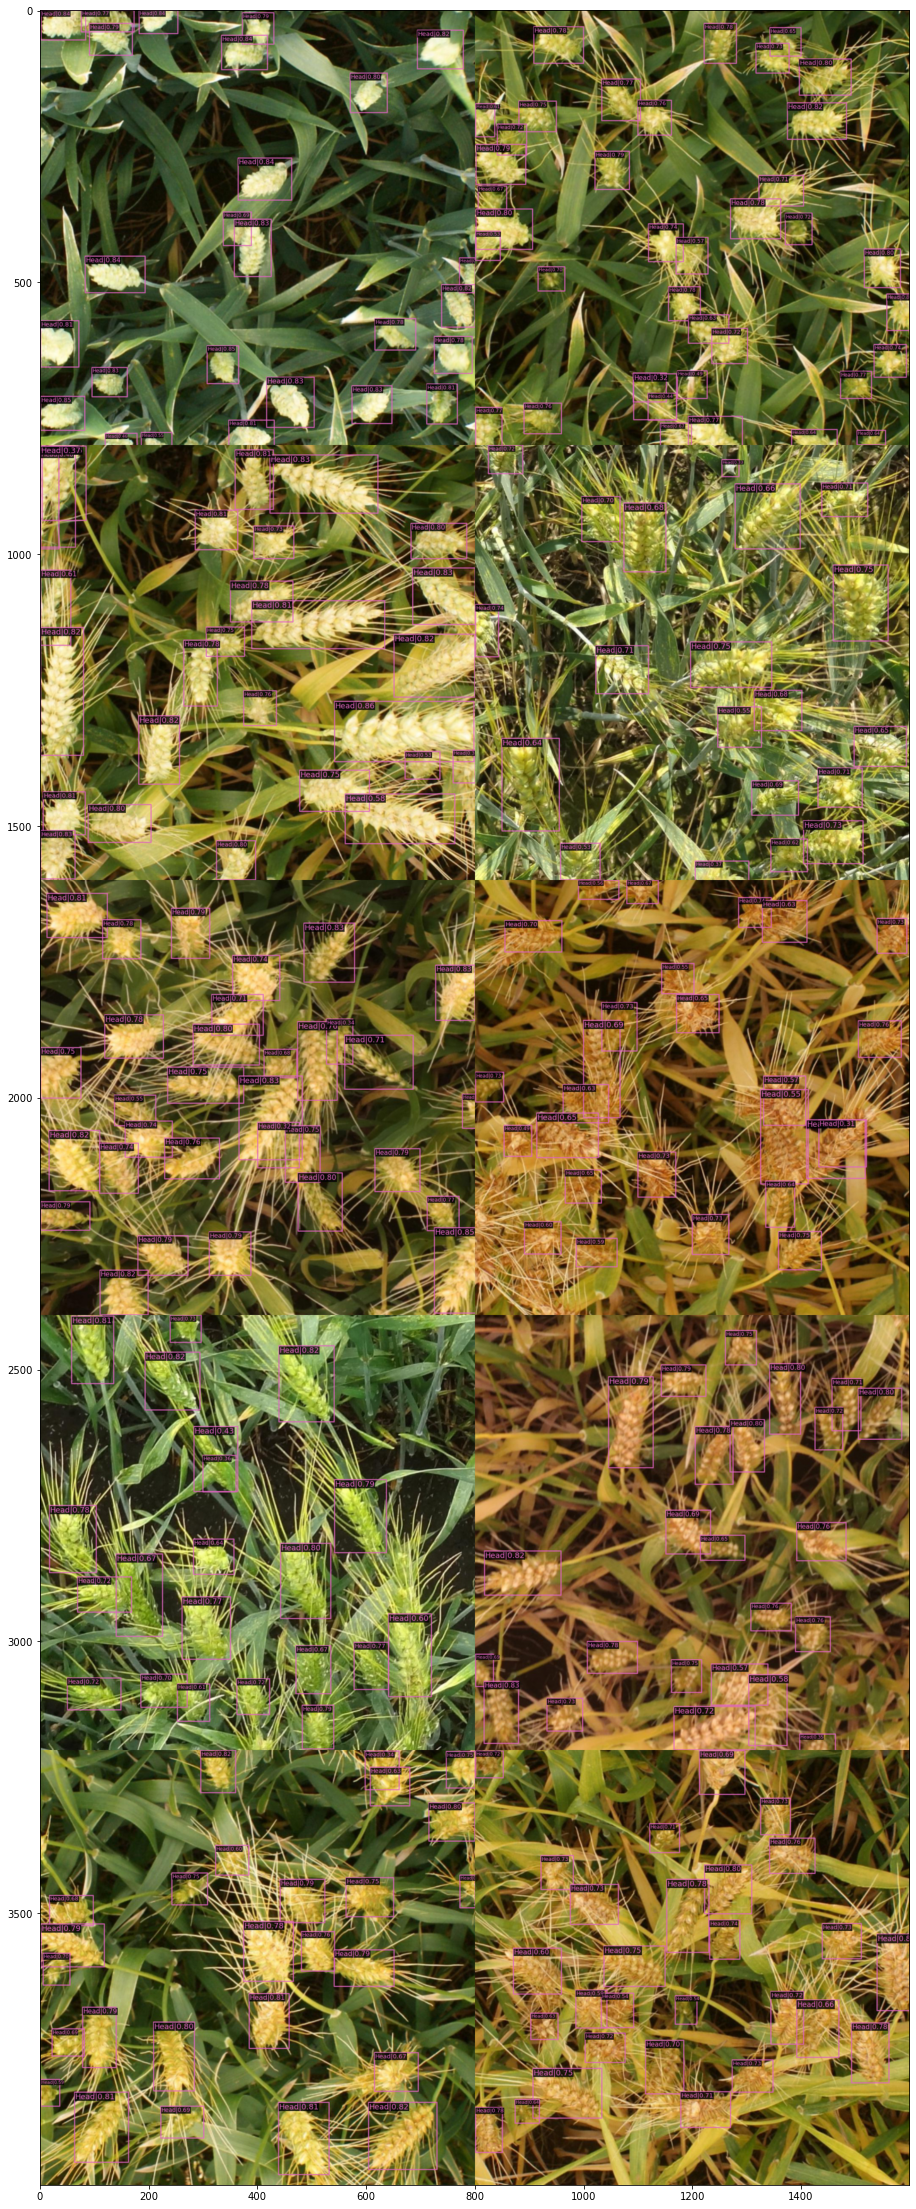

In [5]:
from utils.imgs import show_imgs

show_imgs('tmp_res')

## Models compexity and speed comparison

D:\apps\anaconda\envs\wheat-detection\lib\site-packages\mmcv\cnn\utils\flops_counter.py:431: RuntimeWarning: overflow encountered in long_scalars
  module.__flops__ += int(np.prod(input[0].shape) * output_last_dim)


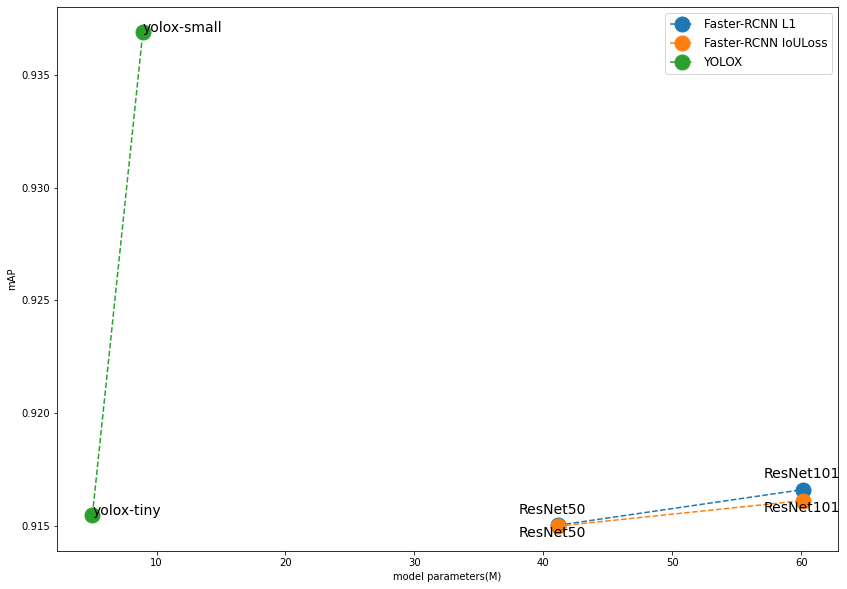

In [1]:
from utils.plots import acc_size_plot

acc_size_plot()

loading annotations for WheatDataset from data/all.txt...
loading annotations for WheatDataset from data/all.txt...
loading annotations for WheatDataset from data/all.txt...
loading annotations for WheatDataset from data/all.txt...
loading annotations for WheatDataset from data/all.txt...


D:\apps\anaconda\envs\wheat-detection\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading annotations for WheatDataset from data/all.txt...


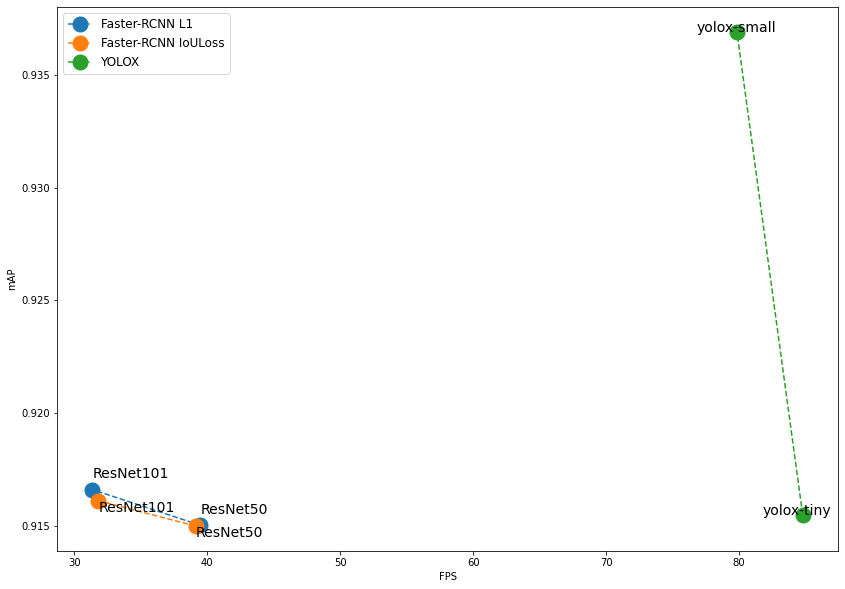

In [1]:
from utils.plots import acc_fps_plot

acc_fps_plot()